# Integrating HWM93 with STK using Python

STK integration with Python opens up a lot of possibilites for working with numerous open science models. 

This script shows an example of incorporating the Horizontal Wind Model 93 (https://ccmc.gsfc.nasa.gov/modelweb/atmos/hwm.html) into STK scenarios. HWM93 is a popular empirical wind model based on satellite and ground-based instrument data. This model is available as Fortran 77 code which can be built in Python using f2py and a fortran compiler (https://github.com/space-physics/hwm93). 

Two example use-cases with the wind model are shown here:
1. HWM93 is used to compute wind components encountered by a Missile object and the data is passed to STK for reporting.
2. A high altitude balloon is simulated by integrating wind speed at each timestep (Just a simple distance = speed x time is done here for demo. Trapezoidal integration or Runge-Kutta higher order methods can be employed if needed)

In [1]:
# Just check python version and make sure it is not 3.7.6 or 3.8.1
from platform import python_version
print(python_version())

3.7.7


#### Import the required libraries:

In [13]:
from comtypes.client import CreateObject
import numpy as np
import os
import math
from datetime import datetime

In [6]:
# add the installed hwm93 library to path and then import
import sys
sys.path.append('C:/Users/ssrivastava/hwm93/')
import hwm93

#### Create STK instance:

In [3]:
stkapp = CreateObject("STK12.Application") #Create new instance of STK
stkapp.Visible = True
stkapp.UserControl = True

In [4]:
stkroot = stkapp.Personality2
from comtypes.gen import STKObjects, STKUtil #These libraries can't be imported before running stkapp.Personality2

Create new scenario and get reference to it:

In [5]:
stkroot.NewScenario("HWM93STKPy")  # Do not have spaces in scenario name
scenario = stkroot.CurrentScenario

In [6]:
# Get the IAgScenario interface
scenario2 = scenario.QueryInterface(STKObjects.IAgScenario)

Set scenario start and stop times:

In [7]:
scenario2.StartTime = "10 Dec 2020 15:00:00.000"
scenario2.StopTime = "11 Dec 2020 15:00:00.000"
stkroot.Rewind(); # reset to the new start time"

## Example 1: Winds encountered by a Missile

In [8]:
# Define a missile using launch, impact coordinates and apogee altitude method

missile = scenario.Children.New(13, 'MyMissile')  # eMissile
missile2 = missile.QueryInterface(STKObjects.IAgMissile)

missile2.SetTrajectoryType(10)  # ePropagatorBallistic
trajectory = missile2.Trajectory
trajectory.StartTime = scenario2.StartTime
trajectory = trajectory.QueryInterface(STKObjects.IAgVePropagatorBallistic)

launchLLA = trajectory.Launch.QueryInterface(STKObjects.IAgVeLaunchLLA)
launchLLA.Lat = 10
launchLLA.Lon = 10

impactLocation = trajectory.ImpactLocation.QueryInterface(STKObjects.IAgVeImpactLocationPoint)
ImpactLLA = impactLocation.Impact.QueryInterface(STKObjects.IAgVeImpactLLA)
ImpactLLA.Lat = 0
ImpactLLA.Lon = 0

impactLocation.SetLaunchControlType(0)  # eLaunchControlFixedApogeeAlt
launchControl = impactLocation.LaunchControl.QueryInterface(STKObjects.IAgVeLaunchControlFixedApogeeAlt)
launchControl.ApogeeAlt = 200    # km

trajectory.Propagate()

0

In [9]:
# Get LLA data for the propagated missile

LLAdata = missile.DataProviders.GetDataPrvTimeVarFromPath('LLA State/Fixed')
elements = ['Time','Lat','Lon','Alt']    # only need time and LLA
results = LLAdata.ExecElements(scenario2.StartTime,scenario2.StopTime,1,elements)    # scenario times in EpSec for convenience, obtained at 1 sec cadence

stkroot.UnitPreferences.SetCurrentUnit("DateFormat","UTCG");    # back to UTCG since HWM93 needs it
missile_t = results.DataSets.GetDataSetByName('Time').GetValues()
missile_lats = results.DataSets.GetDataSetByName('Lat').GetValues()
missile_lons = results.DataSets.GetDataSetByName('Lon').GetValues()
missile_alts = results.DataSets.GetDataSetByName('Alt').GetValues()    # in km

In [10]:
# Use the HWM93 wind model to obtain wind at different points along the trajectory

missile_u = np.zeros(np.shape(missile_lats))    # init
missile_v = np.zeros(np.shape(missile_lats))
for k in range(len(missile_lats)):     
        trajWind = hwm93.run(time = missile_t[k], altkm=missile_alts[k], glat=missile_lats[k], glon=missile_lons[k], f107a = 150, f107=150, ap=4)
        missile_u[k] = trajWind.zonal.values[0]
        missile_v[k] = trajWind.meridional.values[0]       
        k+=1

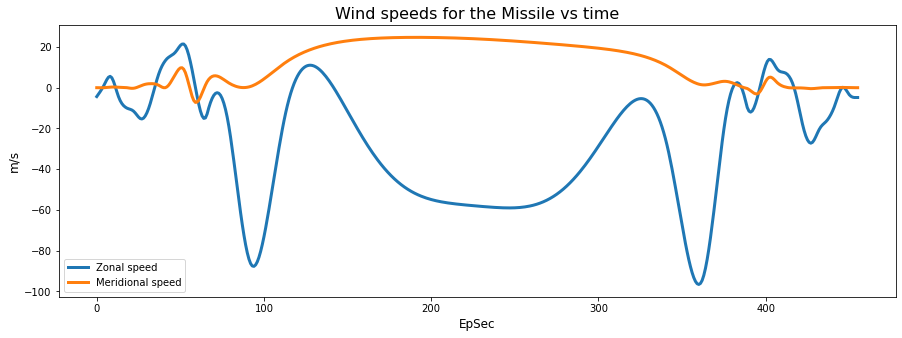

In [13]:
#Create a line plot to visualize wind speeds 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(missile_u, linewidth=3.0, label='Zonal speed')
plt.plot(missile_v, linewidth=3.0, label='Meridional speed')
plt.ylabel('m/s', fontsize=12)
plt.xlabel('EpSec',fontsize=12)
plt.legend()
plt.title('Wind speeds for the Missile vs time', fontsize = 16);

#### Writing missile LLA and wind data to an STK-readable text file:

In [15]:
# Writing block of data to be written in the file
stkroot.UnitPreferences.SetCurrentUnit("DateFormat","EpSec");    # back to EpSec for writing to external file
missile_t_EpSec = results.DataSets.GetDataSetByName('Time').GetValues()
DataToWrite = ''
for k in range(len(missile_lats)):
    line = '%.14e %f %f %f %f %f' % (missile_t_EpSec[k],missile_lats[k],missile_lons[k],missile_alts[k],missile_u[k],missile_v[k])
    DataToWrite += line
    DataToWrite += '\n'

In [16]:
# Formatting data to write as STK-readable text file
ToWrite = """stk.v.12.1 \n
\n
Begin DataGroup\n
GroupName\t Missile Trajetory and Wind
NumberOfPoints\t %d
BlockFactor\t 50
ReferenceEpoch\t %s \n
Begin DataElement
Name\t Lat
Dimension\t Lat
FileUnitAbbr\t deg
InterpOrder\t 1
End DataElement
\n
Begin DataElement
Name\t Lon
Dimension\t Lon
FileUnitAbbr\t deg
InterpOrder\t 1
End DataElement
\n
Begin DataElement
Name\t Alt
Dimension\t DistanceUnit
FileUnitAbbr\t km
InterpOrder\t 1
End DataElement
\n
Begin DataElement
Name\t Zonal Wind
Dimension\t Rate
FileUnitAbbr\t m
FileUnitAbbr\t sec
InterpOrder\t 1
End DataElement
\n
Begin DataElement
Name\t Meridional Wind
Dimension\t Rate
FileUnitAbbr\t m
FileUnitAbbr\t sec
InterpOrder\t 1
End DataElement

Begin Data\n
%s
End Data
""" % (len(missile_lats),missile_t[0],DataToWrite)

In [17]:
# Save the formatted data as a text file
MissileDataFile = open(r"C:\Users\ssrivastava\Documents\STK 12\MissileWindData.txt", "w")
MissileDataFile.write(ToWrite)
MissileDataFile.close()

In [19]:
# Send connect command to send the file as User Defined data (either here or from GUI)
stkroot.ExecuteCommand('ExternalData */Missile/MyMissile ReadFile "C:/Users/ssrivastava/Documents/STK 12/MissileWindData.txt" Save')

<POINTER(IAgExecCmdResult) ptr=0x21d3cb986d8 at 21d3e46ff48>

## Example 2: Simulating a high altitude balloon

#### Create the balloon:

Insert an aircraft object that will be our balloon:

In [20]:
aircraft = scenario.Children.New(STKObjects.eAircraft, "TestBalloon")
aircraft2 = aircraft.QueryInterface(STKObjects.IAgAircraft)

Set Propagator to GreatArc:

In [21]:
aircraft2.SetRouteType(STKObjects.ePropagatorGreatArc)
route = aircraft2.Route.QueryInterface(STKObjects.IAgVePropagatorGreatArc)

#### User inputs here:

In [22]:
deltaT = 30                     # timestep for distance calculation in seconds
alt = 30000                     # meters, alt will not be varied in this example
FirstWayPt = np.array([50,-20]) # starting lat,lon of the balloon
Rearth = 6371000                # Earth's radius in m

# space environment parameters
Setf107a = 150 
Setf107 = 150
Setap = 4

#### Computations:

Setting the units:
(Setting date format to Epoch sec saves the trouble of handling UTCG time strings)

In [23]:
stkroot.UnitPreferences.SetCurrentUnit("DistanceUnit","m"),
stkroot.UnitPreferences.SetCurrentUnit("DateFormat","EpSec");   

Initialize arrays to hold timestep and waypoint data:

In [24]:
timesteps = np.arange(start=scenario2.StartTime, stop=scenario2.StopTime, step = deltaT) # create array of timesteps(size:N)
waypoints = np.zeros([np.size(timesteps),4]) # init array for storing waypoints (size: Nx4 for lat, lon, alt and time)

Function definition to compute LatLon from distance traversed by the balloon:

In [25]:
def Distance2LatLon(Lat1,Lon1,zonal_dist,meridional_dist,Rearth):
    
    """ Function to compute updated lat lon based on zonal and meridional distance traverse.d
        Uses approximate inverse Haversine formula for sphere (good enough!)
        Inputs: Initial coordinates (Lat1, Lon1) in degrees; zonal, meridional distances travelled and Rearth in meters
        Outputs: Update coordinates (Lat2, Lon2) """
    
    # prep values
    dlat = MDist/Rearth
    dlon = ZDist/Rearth
    lat1 = math.radians(Lat1) # convert to radians
    lon1 = math.radians(Lon1)
    
    # compute new lat, lon based on approx. inverse Haversine formula
    lat2 = math.asin(math.sin(lat1)*math.cos(dlat) + math.cos(lat1)*math.sin(dlat))
    lon2 = lon1 + math.atan2(math.sin(dlon)*math.cos(lat1), math.cos(dlon)-math.sin(lat1)*math.sin(lat2))
    
    # convert back to degrees
    Lat2 = math.degrees(lat2)
    Lon2 = math.degrees(lon2)
    
    return Lat2, Lon2

Compute balloon waypoints:

In [26]:
for i in range(0,len(waypoints)):
    if i == 0:
        # Assign values for the first waypoint
        waypoints[i,0] = FirstWayPt[0]  # starting lat
        waypoints[i,1] = FirstWayPt[1]  # starting lon
        waypoints[i,2] = alt
        waypoints[i,3] = scenario2.StartTime
    else: # for all waypoints except the first
        
        # Get the wind info (returned as an xarray structure in m/s)
        # HWM93 wind model requires time input as py datetime object
        PrevTime = stkroot.ConversionUtility.ConvertDate('EpSec','UTCG',str(waypoints[i-1,3])) # step1. Get UTCG string
        PrevTimeObj = datetime.strptime(PrevTime, '%d %b %Y %H:%M:%S.%f') # step2.  convert to py datetime obj
        
        # computing wind at previous way point
        wind = hwm93.run(time = PrevTimeObj, altkm=alt/1000, glat=waypoints[i-1,0], glon=waypoints[i-1,1], f107a = Setf107a, f107=Setf107, ap=Setap)
        
        # Calculate distance traversed in deltaT time
        ZDist = deltaT*wind.zonal.values[0]         # zonal distance traversed in deltaT time (in meters)
        MDist = deltaT*wind.meridional.values[0]    # meridional distance traversed in deltaT time (in meters)
        
        # Calculate next waypoint coordinates
        newLat, newLon = Distance2LatLon(waypoints[i-1,0],waypoints[i-1,1],ZDist,MDist,Rearth)
        
        waypoints[i,0] = newLat       # in degrees
        waypoints[i,1] = newLon       # in degrees
        waypoints[i,2] = alt          # in meters
        waypoints[i,3] = timesteps[i] # in Epoch seconds 

#### Feeding the computed waypoints to STK:

We will use eDetermineVelFromTime calculation method since we have coordinates and timesteps defined

In [27]:
# Set Calculation method and altitude reference
route.Method = STKObjects.eDetermineVelFromTime
route.SetAltitudeRefType(STKObjects.eWayPtAltRefMSL);

Very important to clear any previous waypoints:

In [28]:
# remove any previous waypoints
route.Waypoints.RemoveAll();

Load the computed waypoints using Waypoints.Add() method:

In [29]:
for count in range(0,len(waypoints)):
    point = route.Waypoints.Add()
    point.Latitude = waypoints[count,0]
    point.Longitude = waypoints[count,1]
    point.Altitude = waypoints[count,2]
    point.Time = waypoints[count,3]


Finally, propagate the route:

In [30]:
route.Propagate();

Change to a Balloon 3D model, if available:

In [689]:
#modelfile = aircraft2.VO.Model.ModelData.QueryInterface(STKObjects.IAgVOModelFile)
#modelfile.Filename = os.path.abspath(stkapp.Path[:-3] + "STKData\\VO\\Models\\Misc\\bomb.mdl")

#### Visualizing wind field in Python
To visualize the wind field generated by the model, we can specify a geographical grid, altitude and time.

In [9]:
# Set the grographical coverage
lats = np.arange(-90., 90., 5.)
lons = np.arange(-180., 180., 15.)
LAT, LON = np.meshgrid(lats, lons)
altinkm = 30
Setf107a = 150
Setf107 = 150
Setap = 4

In [10]:
# Set the query time
from datetime import datetime
QueryTime = "10 Dec 2020 15:00:00.000"
QueryTimeObj = datetime.strptime(QueryTime, '%d %b %Y %H:%M:%S.%f')

In [11]:
U = np.zeros(np.shape(LAT))
V = np.zeros(np.shape(LAT))
for j in range(len(lats)):     
    for i in range(len(lons)):
        thisWind = hwm93.run(time = QueryTimeObj, altkm=altinkm, glat=lats[j], glon=lons[i], f107a = Setf107a, f107=Setf107, ap=Setap)
        U[i,j] = thisWind.zonal.values[0]
        V[i,j] = thisWind.meridional.values[0]       
        i+=1
    j+=1

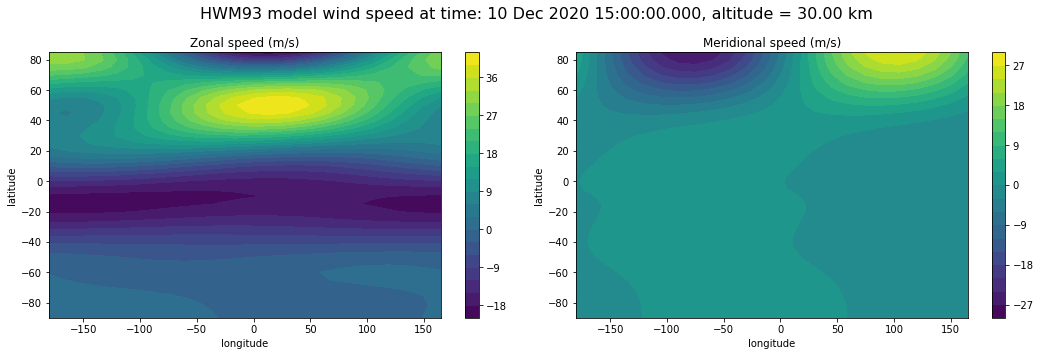

In [14]:
# plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2) # get handles for fig and axes (subplots)
plt.rcParams["figure.figsize"] = (15,5)

# generate first subplot
cntr = ax[0].contourf(lons,lats,np.transpose(U),levels=20)
fig.colorbar(cntr,ax=ax[0])
ax[0].set_title('Zonal speed (m/s)')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
# generate second subplot (using a more concise method)
cntr2 = ax[1].contourf(lons,lats,np.transpose(V),levels=20)
fig.colorbar(cntr2,ax=ax[1])
ax[1].set(title='Meridional speed (m/s)',xlabel='longitude',ylabel='latitude')

# overall attributes
plt.suptitle('HWM93 model wind speed at time: %s, altitude = %.2f km' % (QueryTime,altinkm), fontsize=16) # super title
plt.tight_layout() #ensures no overlap of subplots


Balloon speed can be imported into STK using the same method as in Example 1.